In [5]:
import random
import pandas as pd
import os

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from PIL import Image, ImageFilter

import keras.backend as KerasBackend

from skimage.transform import resize

import time
import numpy
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
import keras
import cv2

import tensorflow as tf
import keras.utils as np_utils


import tqdm

from keras.preprocessing import image
from keras.layers import Lambda
from keras.layers import Concatenate

from keras.callbacks import EarlyStopping
from tqdm import tqdm_notebook as tqdm_NB


import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


from keras.preprocessing.image import ImageDataGenerator

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [6]:
img_size_ori = 101
img_size_target = 128


#Upsample takes a 101 by 101 pixel image and creates an image of 128 by 128.
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

#Downsample returns a 128 by 128 pixel image back to a 101 by 101 pixel size.
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [7]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
#This is the Data to be Trained and Labeled.
X = []
y = []


X_images = []
y_images = []

#Data Paths
train_image_path = r"C:\Users\buckf\Documents\Practicum_2\Data\train\images"
train_mask_path = r"C:\Users\buckf\Documents\Practicum_2\Data\train\masks"


image_list = os.listdir(train_image_path)
mask_list = os.listdir(train_mask_path)

for image_num in range(len(image_list)):
    #Gets the Path to the Mask
    certain_image_path = os.path.join(train_image_path, image_list[image_num])
    image_img = Image.open(certain_image_path).convert('L')
    image_pix = np.array(image_img.getdata()).reshape(image_img.size[0], image_img.size[1], 1)
    X.append(image_pix)
    X_images.append(image_img)

for mask_num in range(len(mask_list)):
    #Gets the Path to the Mask
    certain_mask_path = os.path.join(train_mask_path, mask_list[mask_num])
    mask_img = Image.open(certain_mask_path).convert('L')
    mask_pix = np.array(mask_img.getdata()).reshape(mask_img.size[0], mask_img.size[1], 1)
    y.append(mask_pix)
    y_images.append(mask_img)
    
X = np.array(X, dtype = 'uint8')
y = np.array(y, dtype = 'uint8')


#Convert pixel values between 0 and 1. 
X = np.divide(X, 255)
y = np.divide(y, 255)

#Covert Datatype of Arrays for openCV and IoU functions.
X = X.astype('uint8')
y = y.astype('uint8')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\buckf\\Documents\\Practicum_2\\Data\\train\\images'

In [ ]:
X.shape

In [ ]:
X[1].shape

In [46]:
X[1].max()

1

In [9]:
#This cell upsamples the data to make the pixel even values.

X_128 = []
i = 0
for i in range(X.shape[0]):
    res = np.array(resize(X[i], (128, 128, 1), mode='constant', preserve_range=True))
    X_128.append(res)
    
X_128 = np.array(X_128, dtype='uint8')

y_128 = []
i = 0
for i in range(y.shape[0]):
    res = np.array(resize(X[i], (128, 128, 1), mode='constant', preserve_range=True))
    y_128.append(res)
    
y_128 = np.array(y_128, dtype='uint8')

AttributeError: 'list' object has no attribute 'shape'

In [61]:
X_128[1].max()

0

In [10]:
df_depths = pd.read_csv('data/depths.csv', index_col='id')
df_depths.head()

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783


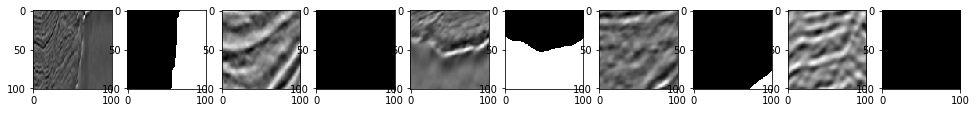

In [11]:
ids= ['4ac19fb269','1825fadf99','f59821d067','5b435fad9d','e340e7bfca']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = image.load_img('data/train/images/' + img_name + '.png')
    img_mask = image.load_img('data/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [12]:
path_train = 'data/train/'
path_test = 'data/test/'

train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [14]:
im_height = 128
im_width = 128
im_chan = 1

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_NB(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = image.load_img(path + '/images/' + id_)
    x = image.img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = image.img_to_array(image.load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 



Done!


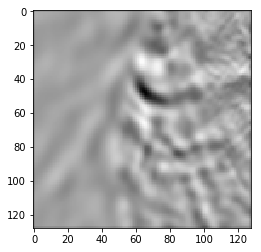

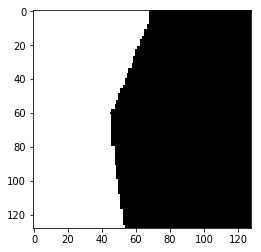

In [15]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [16]:
X_train.shape

(4000, 128, 128, 1)

In [17]:
# Build U-Net model
im_height = 128
im_width = 128
im_chan = 1

def unet(pretrained_weights = None):
    inputs = Input((im_height, im_width, im_chan))
    s = Lambda(lambda x: x / 255) (inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(s)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [mean_iou])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [18]:
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [20]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = merge([u6,c4], mode = 'concat', concat_axis = 3)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = merge([u7,c3], mode = 'concat', concat_axis = 3)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = merge([u8,c2], mode = 'concat', concat_axis = 3)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = merge([u9,c1], mode = 'concat', concat_axis = 3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 128, 128, 8)  80          lambda_2[0][0]                   
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 128, 8)  584         conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [29]:
earlystopper = EarlyStopping(patience=5, verbose=2)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=2, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.3, batch_size=32, epochs=15, verbose= 2, 
                    callbacks=[earlystopper, checkpointer])

Train on 2800 samples, validate on 1200 samples
Epoch 1/15
 - 18s - loss: 0.3044 - mean_iou: 0.5355 - val_loss: 0.3344 - val_mean_iou: 0.5421

Epoch 00001: val_loss improved from inf to 0.33441, saving model to model-tgs-salt-1.h5
Epoch 2/15
 - 19s - loss: 0.2926 - mean_iou: 0.5482 - val_loss: 0.2840 - val_mean_iou: 0.5536

Epoch 00002: val_loss improved from 0.33441 to 0.28405, saving model to model-tgs-salt-1.h5
Epoch 3/15
 - 19s - loss: 0.2705 - mean_iou: 0.5594 - val_loss: 0.2797 - val_mean_iou: 0.5654

Epoch 00003: val_loss improved from 0.28405 to 0.27973, saving model to model-tgs-salt-1.h5
Epoch 4/15
 - 19s - loss: 0.2548 - mean_iou: 0.5713 - val_loss: 0.2602 - val_mean_iou: 0.5778

Epoch 00004: val_loss improved from 0.27973 to 0.26020, saving model to model-tgs-salt-1.h5
Epoch 5/15
 - 19s - loss: 0.2566 - mean_iou: 0.5838 - val_loss: 0.2978 - val_mean_iou: 0.5877

Epoch 00005: val_loss did not improve
Epoch 6/15
 - 19s - loss: 0.2472 - mean_iou: 0.5907 - val_loss: 0.2416 - va

In [30]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_NB(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = image.load_img(path + '/images/' + id_)
    x = image.img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 



Done!


In [31]:
# Predict on train, val and test
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=0)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=0)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA

In [32]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tqdm.tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [35]:
preds_test_upsampled[0].shape

(101, 101)

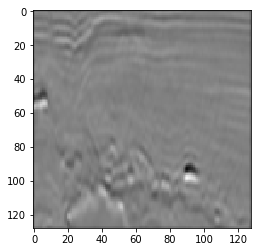

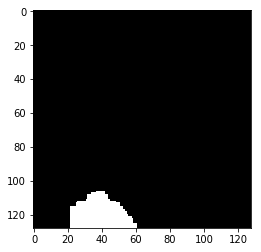

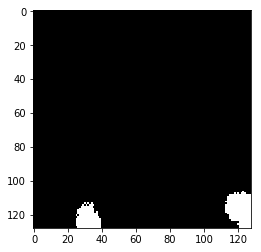

In [43]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [44]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_NB(enumerate(test_ids))}

In [45]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.5, shuffle = True)

In [ ]:
num_pixels = X_train.shape[1] * X_train.shape[2]
num_classes = y_val.shape[1]

def simple_cnn_model():
    
    # create model
### YOUR TURN
# Build a model that has 1 convolution layer, 1 max pooling, 1 dense, and output 
# Use 32 filters with 5x5 size
# For max pooling layer, make the layer such that the featuremap size would be the half after the pooling layer
# hint: you need to change the argument input_shape to (w,h,1) in the first conv layer

    
    
    model = Sequential()
    model.add(ZeroPadding2D(padding=(2,2), input_shape = (X_train.shape[1], X_train.shape[2], 1)))
    
    #Convolution 1:
    model.add(Conv2D(200, kernel_size = (3,3),
                     activation = 'relu',
                     padding = 'same'))
    
    #Convolution 2:
    model.add(Conv2D(50, kernel_size= (2,2), activation='relu', padding='same'))
    
    
    model.add(MaxPooling2D(pool_size=(3,3)))
    
    
    #Convolution 3
    model.add(Conv2D(50, kernel_size= (3,3), activation='relu', padding='same'))
    
    #Convolution 4
    model.add(Conv2D(50, kernel_size= (3,3), activation='relu', padding='same'))
    
    #Max-Pool 2
    model.add(MaxPooling2D(pool_size=(3,3)))
    
    
    model.add(Conv2DTranspose(1, kernel_size= (3,3), activation='relu', padding='same'))
    
    
    model.add(UpSampling2D(size=(3,3)))
    
    
    
    model.add(UpSampling2D(size=(3,3)))
    model.add(ZeroPadding2D(padding=(1,1)))
    
    
    model.compile(loss= keras.losses.binary_crossentropy, optimizer= 'adam' , metrics=[mean_iou])
#     model.compile(loss= keras.losses.mean_squared_error, optimizer= 'adam' , metrics=[mean_iou])
    return model
    

model = simple_cnn_model()
model.summary()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=15, verbose=1)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
datagen.fit(X_train)

In [ ]:
num_pixels = X_train.shape[1] * X_train.shape[2]
num_classes = y_val.shape[1]

def simple_cnn_model():
    
# hint: you need to change the argument input_shape to (w,h,1) in the first conv layer

    
    
    model = Sequential()
    model.add(ZeroPadding2D(padding=(2,2), input_shape = (X_train.shape[1], X_train.shape[2], 1)))
    
    #Convolution 1:
    model.add(Conv2D(200, kernel_size = (3,3),
                     activation = 'relu',
                     padding = 'same'))
    
    #Convolution 2:
    model.add(Conv2D(50, kernel_size= (2,2), activation='relu', padding='same'))
    
    
    model.add(MaxPooling2D(pool_size=(3,3)))
    
    
    
    #Convolution 3
    model.add(Conv2D(50, kernel_size= (3,3), activation='relu', padding='same'))
    
    #Convolution 4
    model.add(Conv2D(50, kernel_size= (3,3), activation='relu', padding='same'))
    
    #Max-Pool 2
    model.add(MaxPooling2D(pool_size=(3,3)))
    
    
    model.add(Conv2DTranspose(1, kernel_size= (3,3), activation='relu', padding='same'))
    
    
    model.add(UpSampling2D(size=(3,3)))
    
    
    
    model.add(UpSampling2D(size=(3,3)))
    model.add(ZeroPadding2D(padding=(1,1)))
    
    
    
    model.compile(loss= keras.losses.binary_crossentropy, optimizer= 'adam' , metrics=[mean_iou])
    return model
    

model = simple_cnn_model()
model.summary()

epochs = 10
model.fit_generator(datagen.flow(X_train, y_val, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=epochs)

In [ ]:
epochs = 10
model.fit_generator(datagen.flow(X_train, y_val, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=epochs)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_val.shape

In [ ]:

# Random Shifts
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
# create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()
break
# Random Shifts
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
# create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()
break